In [ ]:
pip install polars

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import re
import time
import psutil
import tracemalloc
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def track_performance(start_time, mem_start, process):
    end_time = time.time()
    elapsed_time = end_time - start_time
    mem_end = process.memory_info().rss / (1024 * 1024)
    peak_mem = tracemalloc.get_traced_memory()[1] / (1024 * 1024)
    tracemalloc.stop()

    return elapsed_time, mem_end, peak_mem

In [ ]:
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# ---------------------- Clean Data ----------------------

df = pd.read_csv('new_iproperty_dataset.csv')

# Clean Property Title
df['Property Title'] = df['Property Title'].str.split(',').str[0]
df['Property Title'] = df['Property Title'].str.title()

# Clean Property Price
df['Property Price'] = df['Property Price'].str.replace('RM', '', regex=False)
df['Property Price'] = df['Property Price'].str.replace(',', '', regex=False)
df['Property Price'] = pd.to_numeric(df['Property Price'], errors='coerce')
df.rename(columns={'Property Price': 'Property Price (RM)'}, inplace=True)

# Clean Property Location
split_cols = df['Property Location'].str.split(', ', expand=True)
split_cols.columns = ['Property Location (City)', 'Property Location (State)']
df.drop(columns=['Property Location'], inplace=True)
df.insert(2, 'Property Location (City)', split_cols['Property Location (City)'])
df.insert(3, 'Property Location (State)', split_cols['Property Location (State)'])

def parse_property_details(detail):
    if pd.isnull(detail):
        return pd.Series([None, None, None])

    # clean messy code（eg: Â â€¢Â ）
    clean_detail = re.sub(r'[^\x00-\x7F]+', ' ', str(detail))

     # extract Type（all character before Built-up）
    type_match = re.search(r"^(.*?)Built-up", clean_detail, re.IGNORECASE)
    if type_match:
        raw_type = type_match.group(1).strip()
        property_type = re.split(r'\s*\|\s*', raw_type)[0]
    else:
        property_type = None

    # extract Area
    area_match = re.search(r'Built[-\s]*up[^0-9]*([\d,]+)\s*sq\.?\s*ft', clean_detail, re.IGNORECASE)
    area = area_match.group(1).replace(',', '') if area_match else None

    # extract Furnishing status
    furnishing = "Unknown"
    if re.search(r'\bUnfurnished\b', clean_detail, re.IGNORECASE):
        furnishing = 'Unfurnished'
    elif re.search(r'\bPartially Furnished\b', clean_detail, re.IGNORECASE):
        furnishing = 'Partially Furnished'
    elif re.search(r'\bFully Furnished\b', clean_detail, re.IGNORECASE):
        furnishing = 'Fully Furnished'
    elif re.search(r'\bFurnished\b', clean_detail, re.IGNORECASE):
        furnishing = 'Furnished'

    return pd.Series([
        property_type.strip() if property_type else None,
        float(area) if area else None,
        furnishing
    ])


df[['Property Type', 'Property Size (sqft)', 'Property Furnishing Status']] = df['Property Details'].apply(parse_property_details)

# delete Property Details
df = df.drop(columns=['Property Details'])

# Clean Property Agent
df['Property Agent'] = df['Property Agent'].str.title()
df['Property Agent'] = df['Property Agent'].apply(
    lambda x: None if re.search(r'\bsdn\.?\s*bhd\.?\b', str(x), re.IGNORECASE) else x
)

# Drop NaNs in price and Null in property type
df.dropna(subset=['Property Price (RM)'], inplace=True)
df.dropna(subset=['Property Type'], inplace=True)

# Drop illogical property size (lower than 70 sqft)
df = df[df['Property Size (sqft)'] >= 70]

# Drop NaNs in price
df.dropna(subset=['Property Price (RM)'], inplace=True)

df.drop_duplicates(inplace=True)

# Print sample result
print(df.head())

df.to_csv("pandas_iproperty_dataset.csv", index=False)

# record performance
elapsed_pandas, mem_end_pandas, peak_mem_pandas = track_performance(start_time, mem_start, process)
records_pandas = len(df)


           Area                                 Property Title  \
0  perlis-zop7y  Semi D 2 Tingkat - Taman Jaya Diri - Seriab -   
1  perlis-zop7y    Semi D 1 Tingkat - Taman Nyu Indah 2 - Arau   
2  perlis-zop7y                           Taman Seri Manis Dua   
3  perlis-zop7y   Teres 1 Tingkat - Bandar Baharu Putra Height   
4  perlis-zop7y   Teres 1 Tingkat - Bandar Baharu Putra Height   

  Property Location (City) Property Location (State)  Property Price (RM)  \
0                   Kangar                    Perlis             775776.0   
1                     Arau                    Perlis             398000.0   
2                   Kangar                    Perlis             306000.0   
3                     Arau                    Perlis             185000.0   
4                     Arau                    Perlis             210000.0   

  Property Agent                                         Source URL  \
0         Haneef  https://www.iproperty.com.my/sale/perlis-zop7y...  

ValueError: too many values to unpack (expected 3)

In [ ]:
import polars as pl
import re
import time
import psutil
import tracemalloc
import os

# 📌 Start tracking memory and time
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# ---------------------- Load CSV in Lazy Mode ----------------------
df_lazy = pl.read_csv("new_iproperty_dataset.csv").lazy()

# ---------------------- Clean Property Title ----------------------
df_lazy = df_lazy.with_columns([
    pl.col("Property Title")
    .str.split(",")
    .list.get(0)
    .str.to_titlecase()
    .alias("Property Title")
])

# ---------------------- Clean Property Price ----------------------
df_lazy = df_lazy.with_columns([
    pl.col("Property Price")
    .str.replace_all("RM", "")
    .str.replace_all(",", "")
    .str.strip_chars()
    .cast(pl.Float64)
    .alias("Property Price (RM)")
]).drop("Property Price")

# ---------------------- Split Property Location ----------------------
df_lazy = df_lazy.with_columns([
    pl.col("Property Location").str.split(", ").alias("split")
])
df_lazy = df_lazy.with_columns([
    pl.col("split").list.get(0).alias("Property Location (City)"),
    pl.col("split").list.get(1).alias("Property Location (State)")
]).drop(["Property Location", "split"])

# ---------------------- Clean Property Agent ----------------------
df_lazy = df_lazy.with_columns([
    pl.when(
        pl.col("Property Agent")
        .str.to_lowercase()
        .str.contains(r"\bsdn\.?\s*bhd\.?\b")
    ).then(None).otherwise(
        pl.col("Property Agent").str.to_titlecase()
    ).alias("Property Agent")
])

# ---------------------- Drop NaN in Price ----------------------
df_lazy = df_lazy.drop_nulls(subset=["Property Price (RM)"])

# ---------------------- Execute Lazy Plan (collect) ----------------------
df = df_lazy.collect()

# ---------------------- Clean Property Details (Eager Python map) ----------------------
def parse_property_details(detail):
    if detail is None:
        return None, None, None

    clean = re.sub(r'[^\x00-\x7F]+', ' ', str(detail))

    type_match = re.search(r"^(.*?)Built-up", clean, re.IGNORECASE)
    if type_match:
        raw_type = type_match.group(1).strip()
        property_type = re.split(r'\s*\|\s*', raw_type)[0]
    else:
        property_type = None

    area_match = re.search(r'Built[-\s]*up[^0-9]*([\d,]+)\s*sq\.?\s*ft', clean, re.IGNORECASE)
    area = area_match.group(1).replace(',', '') if area_match else None

    furnishing = "Unknown"
    if re.search(r'\bUnfurnished\b', clean, re.IGNORECASE):
        furnishing = 'Unfurnished'
    elif re.search(r'\bPartially Furnished\b', clean, re.IGNORECASE):
        furnishing = 'Partially Furnished'
    elif re.search(r'\bFully Furnished\b', clean, re.IGNORECASE):
        furnishing = 'Fully Furnished'
    elif re.search(r'\bFurnished\b', clean, re.IGNORECASE):
        furnishing = 'Furnished'

    return property_type, float(area) if area else None, furnishing

# Apply custom parsing function
details = df["Property Details"].to_list()
parsed = list(map(parse_property_details, details))
types, areas, furnishings = zip(*parsed)

df = df.with_columns([
    pl.Series("Property Type", types),
    pl.Series("Property Size (sqft)", areas),
    pl.Series("Property Furnishing Status", furnishings)
]).drop("Property Details")

df = df.drop_nulls(subset=["Property Type"])
df = df.filter(pl.col("Property Size (sqft)") >= 70)
df = df.unique()

# ---------------------- Save to CSV ----------------------
df.write_csv("polars_iproperty_dataset.csv")

# ---------------------- Print Sample ----------------------
print(df.head(5))

# ---------------------- Track Performance ----------------------
def track_performance(start_time, mem_start, process):
    elapsed_time = time.time() - start_time
    mem_end = process.memory_info().rss / (1024 * 1024)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    records = df.shape[0]
    throughput = records / elapsed_time if elapsed_time > 0 else 0

    print(f"\n⏱️ Elapsed Time: {elapsed_time:.2f} sec")
    print(f"📊 Memory Used (Start → End): {mem_start:.2f} MB → {mem_end:.2f} MB")
    print(f"🚀 Peak Memory (tracemalloc): {peak / 1024 / 1024:.2f} MB")
    print(f"📈 Throughput: {throughput:,.2f} records/sec")
    return elapsed_time, mem_end, peak / 1024 / 1024, records

elapsed, mem_end, peak, records = track_performance(start_time, mem_start, process)

print(f"📄 Total Records Cleaned: {records}")


shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Area      ┆ Property  ┆ Property  ┆ Source    ┆ … ┆ Property  ┆ Property  ┆ Property  ┆ Property │
│ ---       ┆ Title     ┆ Agent     ┆ URL       ┆   ┆ Location  ┆ Type      ┆ Size      ┆ Furnishi │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ (State)   ┆ ---       ┆ (sqft)    ┆ ng       │
│           ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ str       ┆ ---       ┆ Status   │
│           ┆           ┆           ┆           ┆   ┆ str       ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ brickfiel ┆ Establish ┆ Marcus    ┆ https://w ┆ … ┆ Kuala     ┆ Serviced  ┆ 838.0     ┆ Fully    │
│ ds-fh927  ┆ ment      ┆ Wong      ┆ ww.iprope ┆   ┆ Lumpur    ┆ Residence 

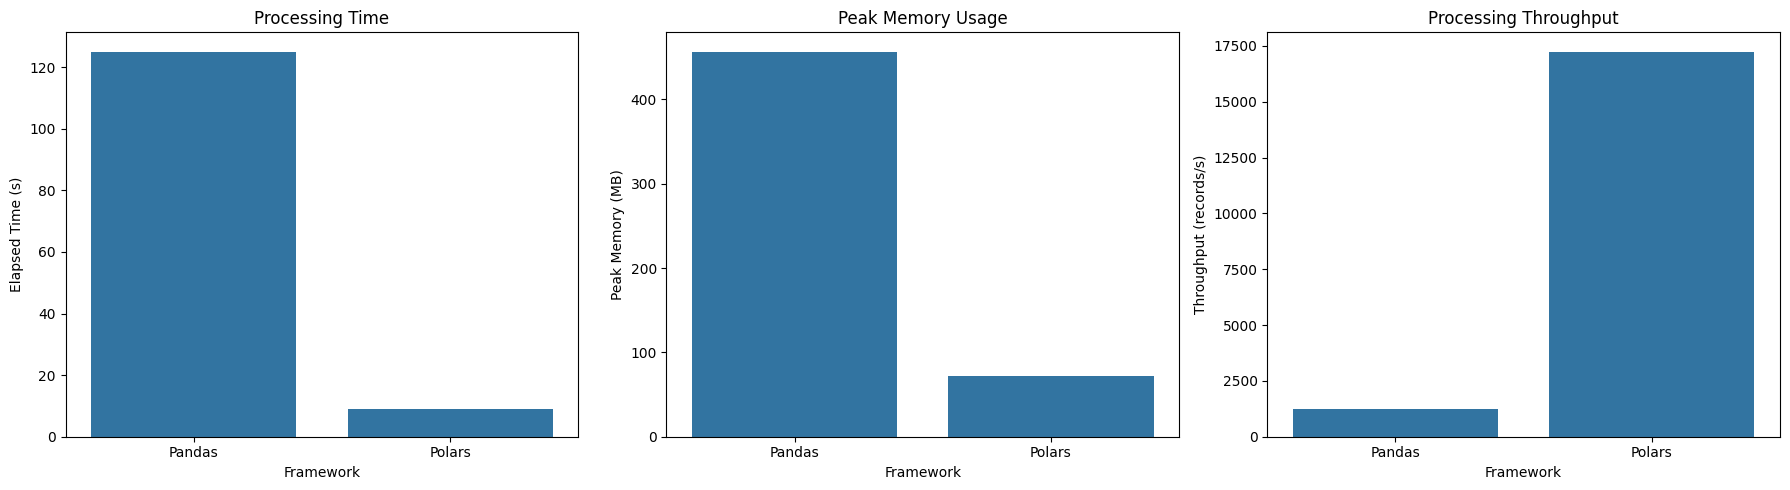

In [ ]:
# 构建 DataFrame 便于可视化
perf_df = pd.DataFrame({
    "Framework": ["Pandas", "Polars"],
    "Elapsed Time (s)": [elapsed_pandas, elapsed],
    "Peak Memory (MB)": [peak_mem_pandas, peak],
    "Records Processed": [records_pandas, records]
})
perf_df["Throughput (records/s)"] = perf_df["Records Processed"] / perf_df["Elapsed Time (s)"]

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=perf_df, x="Framework", y="Elapsed Time (s)", ax=axes[0])
axes[0].set_title("Processing Time")

sns.barplot(data=perf_df, x="Framework", y="Peak Memory (MB)", ax=axes[1])
axes[1].set_title("Peak Memory Usage")

sns.barplot(data=perf_df, x="Framework", y="Throughput (records/s)", ax=axes[2])
axes[2].set_title("Processing Throughput")

plt.tight_layout()
plt.show()
